In [42]:
%cd /app/
import tensorflow as tf
from pathlib import Path
from src.model import create_model
import tensorflow_addons as tfa
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
import pickle
import numpy as np
import matplotlib.pyplot as plt  
from src.dataset import Dataset
from skimage.util import montage
# tf.debugging.set_log_device_placement(True)

/app
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
old_model_path = Path('../checkpoints') /'20200330-183949'
new_model_path = Path('models/20200409-120449/')

In [3]:
labels = Path('labels.txt').read_text()
labels = labels.split('\n')
output_shape = len(labels)
latest = tf.train.latest_checkpoint(str(new_model_path))
print(latest)
model = create_model((224,224, 3), output_shape)

models/20200409-120449/cp037.ckpt
31784960/31782304 [==============================] - 2s 0us/step


In [4]:
latest = 'models/20200409-120449/cp035.ckpt'

In [5]:
ds_train, ds_val, class_weight, le, IMAGE_SIZE, N_CLASSES = Dataset.read(batch_size=22)

In [6]:
model.load_weights(latest)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnet-b2 (Model)      (None, 7, 7, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5),
                      tfa.metrics.F1Score(N_CLASSES,'weighted')])

In [44]:
model.evaluate(ds_val.take(500))

500/500 [==============================] - 47s 95ms/step - loss: 1.5744 - accuracy: 0.6760 - top_k_categorical_accuracy: 0.8660 - f1_score: 0.6754


[1.5743805170059204,
 0.6759999990463257,
 0.8659999966621399,
 0.6754003167152405]

In [35]:
images, labels = next(ds_val.unbatch().batch(100).skip(3).take(1).as_numpy_iterator())

In [36]:
preds = model(images, training=False)
wrong = labels.argmax(axis=1) != tf.argmax(preds,axis=1)

In [37]:
a = images[tf.where(wrong==False).numpy().reshape(-1)]
b = images[tf.where(wrong==True).numpy().reshape(-1)]


In [ ]:
1 = 12/35
2 = 13/42
3 =  5/31

In [40]:
b.shape

(31, 224, 224, 3)

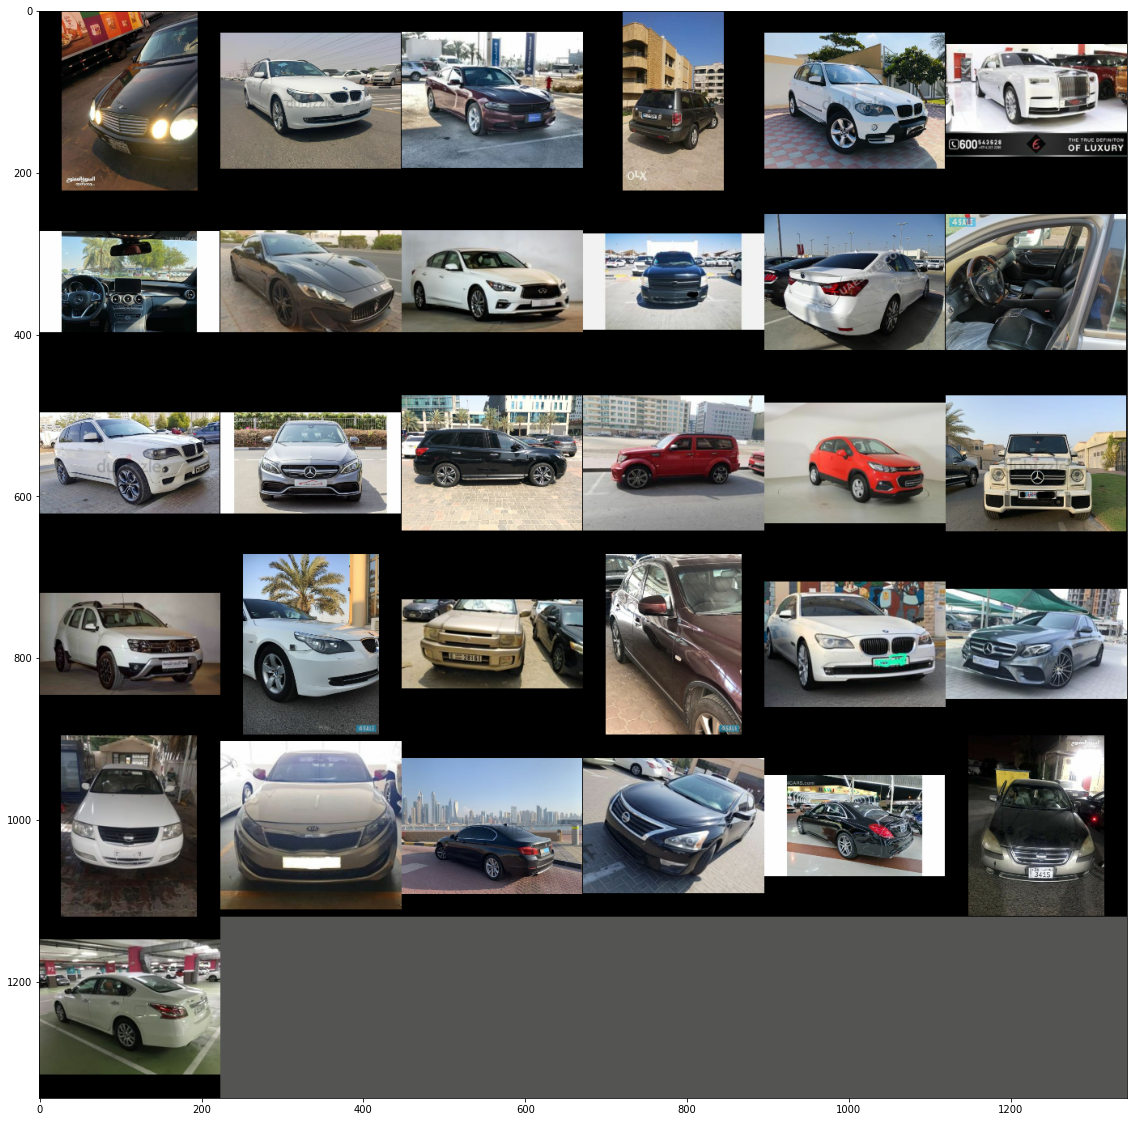

In [39]:
plt.figure(figsize = (20,20))
plt.imshow(montage(b, multichannel=True))

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(montage(a, multichannel=True))
# for x in tf.where(wrong== False):
#     plt.imshow(images[x])
#     plt.figure()

In [ ]:
#model.save('great_model')

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [30]:
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
tflite_model_file = Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)


35843528